# Character RNN Model

In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from typing import List
import subprocess
from dataclasses import dataclass
import tempfile
import os
import types
from pathlib import Path


from keras_visualizer import visualizer
from IPython.display import Image
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (
    Embedding, LSTM, Dense, Bidirectional, Dropout
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [5]:
packages = []

for name, val in globals().items():
    if isinstance(val, types.ModuleType):
        try:
            packages.append(f'{val.__name__}=={val.__version__}')
        except AttributeError:
            continue

print('\n'.join(sorted(set(packages))))

matplotlib==3.6.0
numpy==1.23.2
pandas==1.5.0
tensorflow==2.10.0


In [6]:
os.chdir(os.path.join(Path.home(), 'seinfeld-scripts', 'notebooks'))

In [27]:
@dataclass
class TokenParams:
    distinct_chars: int
    seq_length: int


@dataclass
class ModelConfigs:
    embedding_dim: int = 100
    lstm_units: int = 32
    dense_dim: int = 64
    dropout_prob: float = 0.8
    learning_rate: int = 0.01


@dataclass
class FitConfigs:
    epochs: int
    batch_size: int
    verbose: int

## Read data

In [7]:
with tempfile.TemporaryDirectory() as tmpdir:        
    subprocess.run([
        'kaggle', 
        'datasets', 
        'download', 
        '--dataset=datascilin/seinfeld-scripts',
        f'--path={tmpdir}'
    ])
    subprocess.run(f'unzip {tmpdir}/seinfeld-scripts.zip -d {tmpdir}'.split())
    script_df = pd.read_csv(f'{tmpdir}/scripts.csv')

100%|██████████| 1.09M/1.09M [00:00<00:00, 6.00MB/s]



Archive:  /var/folders/hm/_38_lcyj6r3bnwwpz7ztvd2w0000gn/T/tmpy13iyzml/seinfeld-scripts.zip
  inflating: /var/folders/hm/_38_lcyj6r3bnwwpz7ztvd2w0000gn/T/tmpy13iyzml/scripts.csv  


In [9]:
msk_season = script_df['season'].isin([6, 7])
# msk_episodes = script_df['episode'].isin(np.arange(1, 12))

script_subset_df = script_df[
    msk_season
    # & msk_episodes
]

text = '\n\n'.join(
    script_subset_df['character'] 
    + ': ' 
    + script_subset_df['dialogue']
).lower()

In [10]:
# Load the dataset
total_chars = len(text)
print(f"Length of text: {total_chars} characters")

Length of text: 828242 characters


In [11]:
# Take a look at the first 250 characters in text
print(text[:750])

george: o.k., danny, take a swing. n-no! no! no! you're opening up your shoulder.

tartabull: really?

george: no, not really. i'm just saying this to you because i like to hear myself talk. yes, really!

tartabull: alright, alright.

george: what are all sweatin' for?

tartabull: it's hot in this uniform.

george: hot? what is this?

tartbull: what is what?

george: this uniform, what's it made from?

tartbull: i don't know, cotton?

george: no. this is not cotton. here, lemme see. will you stop it? oh. of course. polyester!

tartabull: so?

george: i can't believe you're not playing in cotton.

tartabull: well, this is what they give us.

george: you know they used to make leisure suits out of this fabric?

tartabull: you really think cot


## Building the Character Vocabulary

In [12]:
# Initialize the Tokenizer class
tokenizer = Tokenizer(char_level=True)

# Generate the word index dictionary
tokenizer.fit_on_texts([text])

# +1 for the padding token
distinct_chars = len(tokenizer.word_index) + 1

print(f"char index dictionary: {tokenizer.word_index}")
print(f"distinct chars: {distinct_chars}")

char index dictionary: {' ': 1, 'e': 2, 'o': 3, 't': 4, 'a': 5, 'r': 6, 'i': 7, 'n': 8, 'h': 9, 's': 10, '\n': 11, 'l': 12, 'y': 13, '.': 14, 'u': 15, 'g': 16, 'm': 17, 'd': 18, 'w': 19, ':': 20, 'c': 21, 'k': 22, ',': 23, "'": 24, 'b': 25, 'p': 26, 'f': 27, 'j': 28, '?': 29, 'v': 30, '!': 31, '-': 32, 'x': 33, 'z': 34, '`': 35, 'q': 36, '*': 37, '0': 38, '1': 39, '2': 40, '5': 41, '3': 42, '4': 43, '#': 44, '8': 45, ';': 46, '9': 47, '7': 48, '[': 49, ']': 50, '6': 51, '/': 52, '$': 53, '(': 54, '&': 55, '%': 56, ')': 57, '_': 58, '{': 59, '}': 60}
distinct chars: 61


## Preprocessing the Dataset

```
INPUT                                        LABEL
------------------------------------------------------------------------------
what's the deal with airplane pea    --->    hat's the deal with airplane pean 
hat's the deal with airplane pean    --->    at's the deal with airplane peanu
at's the deal with airplane peanu    --->    t's the deal with airplane peanut
t's the deal with airplane peanut    --->    's the deal with airplane peanuts
```

In [15]:
token_params = TokenParams(
    distinct_chars=distinct_chars, 
    seq_length = 100
)

In [16]:
def encode(text: str) -> List :
    return tokenizer.texts_to_sequences([text])[0]

encoded_text = encode(text)

In [17]:
# Take a look at the first 250 characters in tokens
sample_encoded_text = encoded_text[:750]
print(sample_encoded_text)

[16, 2, 3, 6, 16, 2, 20, 1, 3, 14, 22, 14, 23, 1, 18, 5, 8, 8, 13, 23, 1, 4, 5, 22, 2, 1, 5, 1, 10, 19, 7, 8, 16, 14, 1, 8, 32, 8, 3, 31, 1, 8, 3, 31, 1, 8, 3, 31, 1, 13, 3, 15, 24, 6, 2, 1, 3, 26, 2, 8, 7, 8, 16, 1, 15, 26, 1, 13, 3, 15, 6, 1, 10, 9, 3, 15, 12, 18, 2, 6, 14, 11, 11, 4, 5, 6, 4, 5, 25, 15, 12, 12, 20, 1, 6, 2, 5, 12, 12, 13, 29, 11, 11, 16, 2, 3, 6, 16, 2, 20, 1, 8, 3, 23, 1, 8, 3, 4, 1, 6, 2, 5, 12, 12, 13, 14, 1, 7, 24, 17, 1, 28, 15, 10, 4, 1, 10, 5, 13, 7, 8, 16, 1, 4, 9, 7, 10, 1, 4, 3, 1, 13, 3, 15, 1, 25, 2, 21, 5, 15, 10, 2, 1, 7, 1, 12, 7, 22, 2, 1, 4, 3, 1, 9, 2, 5, 6, 1, 17, 13, 10, 2, 12, 27, 1, 4, 5, 12, 22, 14, 1, 13, 2, 10, 23, 1, 6, 2, 5, 12, 12, 13, 31, 11, 11, 4, 5, 6, 4, 5, 25, 15, 12, 12, 20, 1, 5, 12, 6, 7, 16, 9, 4, 23, 1, 5, 12, 6, 7, 16, 9, 4, 14, 11, 11, 16, 2, 3, 6, 16, 2, 20, 1, 19, 9, 5, 4, 1, 5, 6, 2, 1, 5, 12, 12, 1, 10, 19, 2, 5, 4, 7, 8, 24, 1, 27, 3, 6, 29, 11, 11, 4, 5, 6, 4, 5, 25, 15, 12, 12, 20, 1, 7, 4, 24, 10, 1, 9, 3, 4, 1, 7, 8,

In [18]:
# when char_level = True, sequences_to_texts puts spaces between characters during decoding
def decode(
    tokenizer: tf.keras.preprocessing.text.Tokenizer, 
    tokenized_text: List
) -> str:
    return ''.join([
        tokenizer.sequences_to_texts([[token]])[0] 
        for token 
        in tokenized_text
    ])

In [19]:
sample_decoded_text = decode(tokenizer, sample_encoded_text)
print(sample_decoded_text)

george: o.k., danny, take a swing. n-no! no! no! you're opening up your shoulder.

tartabull: really?

george: no, not really. i'm just saying this to you because i like to hear myself talk. yes, really!

tartabull: alright, alright.

george: what are all sweatin' for?

tartabull: it's hot in this uniform.

george: hot? what is this?

tartbull: what is what?

george: this uniform, what's it made from?

tartbull: i don't know, cotton?

george: no. this is not cotton. here, lemme see. will you stop it? oh. of course. polyester!

tartabull: so?

george: i can't believe you're not playing in cotton.

tartabull: well, this is what they give us.

george: you know they used to make leisure suits out of this fabric?

tartabull: you really think cot


In [20]:
%%time

seq_length = token_params.seq_length
xs = []
ys = []
for i in range(0, total_chars):
    xs.append(
        pad_sequences(
            [encoded_text[i:seq_length + i]], 
            maxlen=seq_length, 
            padding="pre"
        )[0]
    )
    ys.append(
        pad_sequences(
            [encoded_text[1 + i:seq_length + 1 + i]], 
            maxlen=seq_length, 
            padding="pre"
        )[0]
    )
    
xs = np.array(xs)
ys = np.array(ys)

CPU times: user 16.7 s, sys: 638 ms, total: 17.4 s
Wall time: 17.4 s


In [22]:
for i in range(2):
    print(f'xs[{i}]: {xs[i]}')
    print(f'decoded xs[{i}]: {decode(tokenizer, xs[i])}')
    print()
    print(f'ys[{i}]: {ys[i]}')
    print(f'decoded ys[{i}]: {decode(tokenizer, ys[i])}')
    print('\n================================================\n')

xs[0]: [16  2  3  6 16  2 20  1  3 14 22 14 23  1 18  5  8  8 13 23  1  4  5 22
  2  1  5  1 10 19  7  8 16 14  1  8 32  8  3 31  1  8  3 31  1  8  3 31
  1 13  3 15 24  6  2  1  3 26  2  8  7  8 16  1 15 26  1 13  3 15  6  1
 10  9  3 15 12 18  2  6 14 11 11  4  5  6  4  5 25 15 12 12 20  1  6  2
  5 12 12 13]
decoded xs[0]: george: o.k., danny, take a swing. n-no! no! no! you're opening up your shoulder.

tartabull: really

ys[0]: [ 2  3  6 16  2 20  1  3 14 22 14 23  1 18  5  8  8 13 23  1  4  5 22  2
  1  5  1 10 19  7  8 16 14  1  8 32  8  3 31  1  8  3 31  1  8  3 31  1
 13  3 15 24  6  2  1  3 26  2  8  7  8 16  1 15 26  1 13  3 15  6  1 10
  9  3 15 12 18  2  6 14 11 11  4  5  6  4  5 25 15 12 12 20  1  6  2  5
 12 12 13 29]
decoded ys[0]: eorge: o.k., danny, take a swing. n-no! no! no! you're opening up your shoulder.

tartabull: really?


xs[1]: [ 2  3  6 16  2 20  1  3 14 22 14 23  1 18  5  8  8 13 23  1  4  5 22  2
  1  5  1 10 19  7  8 16 14  1  8 32  8  3 31  1  8  3 31  

## Building the model

In [23]:
def build_and_compile_model(model_configs: ModelConfigs, 
                            token_params: TokenParams
                           ) -> tf.keras.Model: 

    model = Sequential(
        [
            Embedding(
                input_dim=token_params.distinct_chars, 
                output_dim=model_configs.embedding_dim, 
                input_length=token_params.seq_length
            ),
            Bidirectional(
                LSTM(model_configs.lstm_units, return_sequences=True)
            ),
            Dense(model_configs.dense_dim),
            Dropout(model_configs.dropout_prob),
            Dense(
                token_params.distinct_chars, 
            ),  # not using softmax activation here, using the logits instead
        ]
    )

    # Use categorical crossentropy because this is a multi-class problem
    model.compile(
        loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=model_configs.learning_rate
        ), 
    )
    
    return model

In [34]:
# Print the model summary
model_tune_configs = ModelConfigs(
    embedding_dim=100,
    lstm_units=32,
    dense_dim=64,
    dropout_prob=0.8,
    learning_rate=0.01,
)
model_tune = build_and_compile_model(model_tune_configs, token_params)
model_tune.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          6100      
                                                                 
 bidirectional_1 (Bidirectio  (None, 100, 64)          34048     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 100, 64)           4160      
                                                                 
 dropout_1 (Dropout)         (None, 100, 64)           0         
                                                                 
 dense_3 (Dense)             (None, 100, 61)           3965      
                                                                 
Total params: 48,273
Trainable params: 48,273
Non-trainable params: 0
__________________________________________________

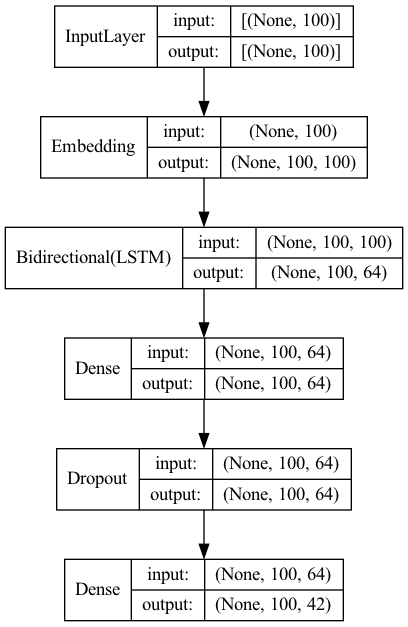

In [99]:
tf.keras.utils.plot_model(
    model_tune, 
    show_shapes=True, 
    show_layer_names=False
) 

## Training the model

### Learning rate tuning

In [100]:
fit_tune_configs = FitConfigs(epochs=50, batch_size=512, verbose=1)

In [ ]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10 ** (epoch / 20)
)

history = model_tune.fit(  # Train the model
    xs, 
    ys, 
    epochs=fit_tune_configs.epochs, 
    batch_size=fit_tune_configs.batch_size, 
    callbacks=[lr_schedule],
    verbose=fit_tune_configs.verbose
)

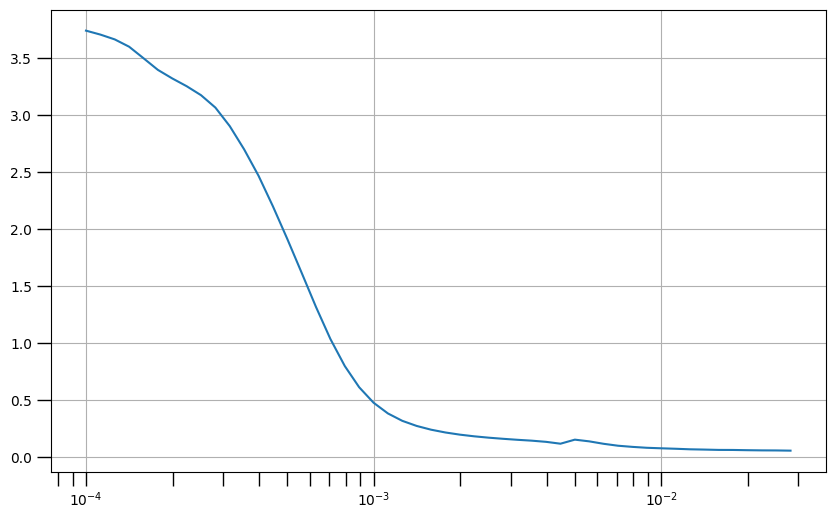

In [97]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(history.history['lr'], history.history["loss"])

# Increase the tickmarks size
plt.tick_params("both", length=10, width=1, which="both")

### Full training

Metal device set to: Apple M1


2022-11-24 22:59:05.205044: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-24 22:59:05.205186: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 150)          9150      
                                                                 
 bidirectional (Bidirectiona  (None, 100, 256)         285696    
 l)                                                              
                                                                 
 dense (Dense)               (None, 100, 64)           16448     
                                                                 
 dropout (Dropout)           (None, 100, 64)           0         
                                                                 
 dense_1 (Dense)             (None, 100, 61)           3965      
                                                                 
Total params: 315,259
Trainable params: 315,259
Non-trainable params: 0
__________________________________________________

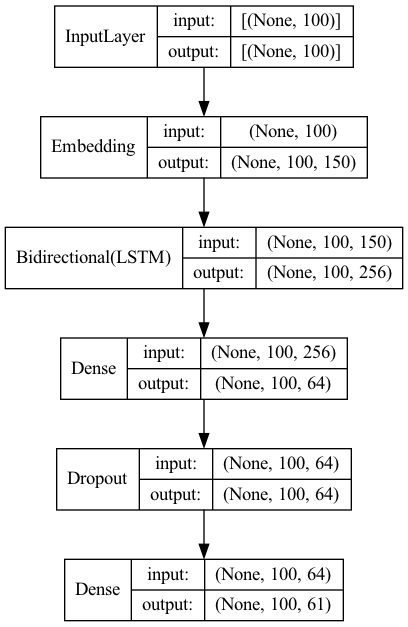

In [25]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

model_configs = ModelConfigs(
    embedding_dim=150,
    lstm_units=128,
    dense_dim=64,
    dropout_prob=0.8,
    learning_rate=1e-3,
)

model = build_and_compile_model(model_configs, token_params)
model.summary()

tf.keras.utils.plot_model(
    model, 
    show_shapes=True, 
    show_layer_names=False
) 

In [28]:
%%time

fit_configs = FitConfigs(
    epochs=50, 
    batch_size=512, 
    verbose=1
)
history = model.fit(  # Train the model
    xs, 
    ys, 
    epochs=fit_configs.epochs, 
    batch_size=fit_configs.batch_size, 
    verbose=fit_configs.verbose
)

Epoch 1/50


2022-11-24 23:01:42.180508: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-24 23:01:42.968957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-24 23:01:43.416811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-24 23:01:43.444681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-24 23:01:46.754619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-24 23:01:46.807470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  71/1618 [>.............................] - ETA: 8:13 - loss: 3.2723

KeyboardInterrupt: 

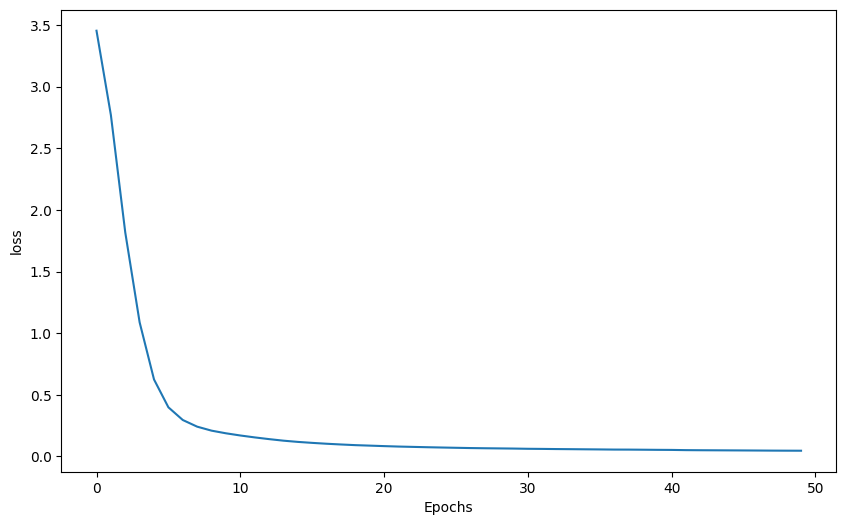

In [121]:
def plot_graphs(history, metric):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history[metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.show()

plot_graphs(history, "loss")

## Generating new dialogue

In [122]:
%%time

characters_to_predict = 1500
seed_text = decode(tokenizer, xs[0, :])

make_random = True

print(f'SEED TEXT:')
print('=================================================')
print(seed_text)
print('=================================================\n')

for i in range(characters_to_predict):
    encoded_seed_text = encode(seed_text)
    padded_seed_text = np.expand_dims(
        pad_sequences([encoded_seed_text], maxlen=seq_length, padding="pre")[0], 0
    )
    pred = model.predict(padded_seed_text, verbose=0)[0]
    
    # get the last set of probabilities for the character prediction
    preds_for_last_char = pred[-1]
    
    if make_random:
        # Pick a token from a multinomial distribution defined by the output logit layer
        token_draw = tf.random.categorical([preds_for_last_char], 1).numpy()[0][0]
    else:
        # Get the most likely token as the character prediction
        token_draw = np.argmax(preds_for_last_char)
    
    predicted_text = decode(tokenizer, [token_draw])
    seed_text += predicted_text

print(f'PREDICTED TEXT:')
print('=================================================')
print(seed_text)
print('=================================================')

SEED TEXT:
george: well, you got no place to go. i'll tell you what your problem is you brought your queen out 



2022-11-24 19:24:57.748601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-24 19:24:57.940948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-24 19:24:57.950694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


PREDICTED TEXT:
george: well, you got no place to go. i'll tell you what your problem is you brought your queen out lchhroitt rrayxrosthe an-lthrm bbout eed youw goo?

george: -ehmasxaan


jerry: dons tge seking tmand?


deaando: vell: haxqeecanf daeg read, iixcxo! lbng djenry bernth y: !



kraak: wedd:  wal's nog sk: iuwh: hef tnoww ssff tnac thhctu xarwmdiyxsoumrelq]



!eirry: me`lllay: go


newhan: th'p noc epqoout , hhan


jerrry: , ho tthiaq


excanxxo:  reth taa


jerry: ualed nry !onrtsc reasge. 


jerry: rek

george: ]

jerry: yiu tog.

jerry: 3ij. ggonpleidb cto

jegry: one am5?

newwaan: you , tgiing twlat sthhh's 5bou4 tthhei


weaane: hey-lak


newmand: oels you bnnt hat lnnow didhhspyou 


kramee: het`


jerry: ang : umankt he, ihxaizh. dyoug3 zhat- noull eve',  tovent:  ?

george:  .


verry: etla thell` onll: unhf kn herf do?

jerry: reylay .



kramege: oell ment hirme .

jerry: orre5f re, !

kramer: hoge.


eeiige: . go.


4elayd:  thaa,  th ouf juldog!

..  o`: hoxl